In [203]:
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
import music21
import ast
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report

from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE


In [204]:
df = pd.read_csv('./data/preprocessed_tuple_with_midi.csv')

In [205]:
print(df['note_tuple'][0][0])

[


In [206]:
df['encoded_note_tuple'] = df['note_tuple'].apply(lambda x: ast.literal_eval(x))

In [207]:
print(df['encoded_note_tuple'][0][0])

(-1, 4.0, 2.0)


## More preprocessing. Zero pad arrays

In [208]:
MAX_LEN = 500

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   midi_file           1530 non-null   object
 1   composer            1530 non-null   object
 2   path                1530 non-null   object
 3   note_tuple          1530 non-null   object
 4   encoded_note_tuple  1530 non-null   object
dtypes: object(5)
memory usage: 59.9+ KB


In [210]:
df.head()

,midi_file,composer,path,note_tuple,encoded_note_tuple
0,Bwv0997 Partita for Lute 1mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 2.0), (48, 4.0, 4.0), (72, 6.0, 1.0...","[(-1, 4.0, 2.0), (48, 4.0, 4.0), (72, 6.0, 1.0..."
1,Bwv0535 Prelude and Fugue.mid,Bach,./data/Bach/,"[(-1, 4.0, 16.0), (55, 4.0, 1.0), (-1, 4.0, 16...","[(-1, 4.0, 16.0), (55, 4.0, 1.0), (-1, 4.0, 16..."
2,Bwv0806 English Suite n1 05mov.mid,Bach,./data/Bach/,"[(69, 4.0, 2.0), (-1, 4.0, 2.0), (69, 5.0, 9.3...","[(69, 4.0, 2.0), (-1, 4.0, 2.0), (69, 5.0, 9.3..."
3,Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.0), (39, 4.0, 4.0), (-1, 4.0, 6.0...","[(-1, 4.0, 1.0), (39, 4.0, 4.0), (-1, 4.0, 6.0..."
4,Jesu Joy of Man Desiring.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.33), (-1, 4.0, 1.33), (-1, 4.0, 4...","[(-1, 4.0, 1.33), (-1, 4.0, 1.33), (-1, 4.0, 4..."


In [211]:
def extract_first_last_tuples(sequences, total_len=MAX_LEN):
    seq_len = len(sequences)
    half_len = total_len // 2
    if seq_len >= total_len:
        # If the sequence is longer than or equal to total_len, take the first and last 
        first_half = sequences[:half_len]
        last_half = sequences[-half_len:]
        combined = first_half + last_half
    else:
        combined = sequences

    # Pad to the total length
    combined = pad_sequences([combined], maxlen=total_len, padding='post', truncating='post', dtype='float32')[0]
    
    return combined


In [212]:
df['first_last_tuples'] = df['encoded_note_tuple'].apply(lambda x: extract_first_last_tuples(x))


In [213]:
df.head()

,midi_file,composer,path,note_tuple,encoded_note_tuple,first_last_tuples
0,Bwv0997 Partita for Lute 1mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 2.0), (48, 4.0, 4.0), (72, 6.0, 1.0...","[(-1, 4.0, 2.0), (48, 4.0, 4.0), (72, 6.0, 1.0...","[[-1.0, 4.0, 2.0], [48.0, 4.0, 4.0], [72.0, 6...."
1,Bwv0535 Prelude and Fugue.mid,Bach,./data/Bach/,"[(-1, 4.0, 16.0), (55, 4.0, 1.0), (-1, 4.0, 16...","[(-1, 4.0, 16.0), (55, 4.0, 1.0), (-1, 4.0, 16...","[[-1.0, 4.0, 16.0], [55.0, 4.0, 1.0], [-1.0, 4..."
2,Bwv0806 English Suite n1 05mov.mid,Bach,./data/Bach/,"[(69, 4.0, 2.0), (-1, 4.0, 2.0), (69, 5.0, 9.3...","[(69, 4.0, 2.0), (-1, 4.0, 2.0), (69, 5.0, 9.3...","[[69.0, 4.0, 2.0], [-1.0, 4.0, 2.0], [69.0, 5...."
3,Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.0), (39, 4.0, 4.0), (-1, 4.0, 6.0...","[(-1, 4.0, 1.0), (39, 4.0, 4.0), (-1, 4.0, 6.0...","[[-1.0, 4.0, 1.0], [39.0, 4.0, 4.0], [-1.0, 4...."
4,Jesu Joy of Man Desiring.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.33), (-1, 4.0, 1.33), (-1, 4.0, 4...","[(-1, 4.0, 1.33), (-1, 4.0, 1.33), (-1, 4.0, 4...","[[-1.0, 4.0, 1.33], [-1.0, 4.0, 1.33], [-1.0, ..."


In [235]:
# from sklearn.preprocessing import StandardScaler

# Extract the first values from the tuples
# first_values = np.array([t[0] for t in df['first_last_tuples'].apply(lambda x: x)])

# Initialize the StandardScaler

# Fit the scaler to the first values and transform them

df['scaled_tuples'] = df['first_last_tuples'].apply(
    lambda x: [(0 if t[0] < 0 else t[0], t[1] / 4, t[2] / 4) for i, t in enumerate(x)]
)

# Display the result
print(df['scaled_tuples'].head())


0    [(0, 1.0, 0.5), (48.0, 1.0, 1.0), (72.0, 1.5, ...
1    [(0, 1.0, 4.0), (55.0, 1.0, 0.25), (0, 1.0, 4....
2    [(69.0, 1.0, 0.5), (0, 1.0, 0.5), (69.0, 1.25,...
3    [(0, 1.0, 0.25), (39.0, 1.0, 1.0), (0, 1.0, 1....
4    [(0, 1.0, 0.33250001072883606), (0, 1.0, 0.332...
Name: scaled_tuples, dtype: object


In [236]:
X = np.array(df['scaled_tuples'].tolist())


In [237]:
df.head()

,midi_file,composer,path,note_tuple,encoded_note_tuple,first_last_tuples,scaled_tuples
0,Bwv0997 Partita for Lute 1mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 2.0), (48, 4.0, 4.0), (72, 6.0, 1.0...","[(-1, 4.0, 2.0), (48, 4.0, 4.0), (72, 6.0, 1.0...","[[-1.0, 4.0, 2.0], [48.0, 4.0, 4.0], [72.0, 6....","[(0, 1.0, 0.5), (48.0, 1.0, 1.0), (72.0, 1.5, ..."
1,Bwv0535 Prelude and Fugue.mid,Bach,./data/Bach/,"[(-1, 4.0, 16.0), (55, 4.0, 1.0), (-1, 4.0, 16...","[(-1, 4.0, 16.0), (55, 4.0, 1.0), (-1, 4.0, 16...","[[-1.0, 4.0, 16.0], [55.0, 4.0, 1.0], [-1.0, 4...","[(0, 1.0, 4.0), (55.0, 1.0, 0.25), (0, 1.0, 4...."
2,Bwv0806 English Suite n1 05mov.mid,Bach,./data/Bach/,"[(69, 4.0, 2.0), (-1, 4.0, 2.0), (69, 5.0, 9.3...","[(69, 4.0, 2.0), (-1, 4.0, 2.0), (69, 5.0, 9.3...","[[69.0, 4.0, 2.0], [-1.0, 4.0, 2.0], [69.0, 5....","[(69.0, 1.0, 0.5), (0, 1.0, 0.5), (69.0, 1.25,..."
3,Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.0), (39, 4.0, 4.0), (-1, 4.0, 6.0...","[(-1, 4.0, 1.0), (39, 4.0, 4.0), (-1, 4.0, 6.0...","[[-1.0, 4.0, 1.0], [39.0, 4.0, 4.0], [-1.0, 4....","[(0, 1.0, 0.25), (39.0, 1.0, 1.0), (0, 1.0, 1...."
4,Jesu Joy of Man Desiring.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.33), (-1, 4.0, 1.33), (-1, 4.0, 4...","[(-1, 4.0, 1.33), (-1, 4.0, 1.33), (-1, 4.0, 4...","[[-1.0, 4.0, 1.33], [-1.0, 4.0, 1.33], [-1.0, ...","[(0, 1.0, 0.33250001072883606), (0, 1.0, 0.332..."


In [238]:
print(X.shape)

(1530, 500, 3)


In [239]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['composer'])


In [240]:
def apply_smote(X, y):
    smote = SMOTE(random_state=42)  

    num_samples, num_timesteps, num_features = X.shape
    X_flatten = X.reshape(num_samples, -1)

    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_flatten, y)

    print(pd.Series(y_smote).value_counts())
    X_smote_reshaped = X_smote.reshape(X_smote.shape[0], num_timesteps, num_features)

    return X_smote_reshaped, y_smote

In [241]:
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.8, random_state=42)

# Need to apply smote to training before we convert to categorical
num_classes = len(label_encoder.classes_)
y_temp = to_categorical(y_temp, num_classes=num_classes)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [242]:
print(X_train.shape, y_train.shape)

(1224, 500, 3) (1224,)


In [243]:
print(df.shape)

(1530, 7)


In [244]:
# X_train, y_train = apply_smote(X_train, y_train)

In [245]:
print(X_train.shape, y_train.shape)

(1224, 500, 3) (1224,)


In [246]:
y_train = to_categorical(y_train, num_classes=num_classes)

In [247]:
input_shape = X_train.shape[1:]

In [248]:
# y_pred = cnn_model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)

# print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

In [249]:

class CNNHyperModel(kt.HyperModel):
    """
    CNN model for hyperparameter tuning using Keras Tuner.
    The keras Tuner doesn't support epochs or batch_size as a parameter, so I overloaded the fit method to include them.
    """
    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(filters=hp.Int('filters_1', min_value=64, max_value=192, step=64),
                        kernel_size=3,
                        activation='relu',
                        kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.0001])),
                        input_shape=input_shape))
        model.add(MaxPooling1D(2))
        model.add(Dropout(hp.Choice('dropout_1', [0.2, 0.3, 0.4])))
        
        if hp.Boolean('add_second_conv_layer'):
            model.add(Conv1D(filters=hp.Int('filters_2', min_value=64, max_value=192, step=64),
                            kernel_size=3,
                            activation='relu',
                            kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.0001]))))
            model.add(MaxPooling1D(2))
            model.add(Dropout(hp.Choice('dropout_2', [0.2, 0.3, 0.4])))
        
        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                        activation='relu',
                        kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.0001]))))
        model.add(Dropout(hp.Choice('dropout_3', [0.2, 0.3, 0.4])))
        
        model.add(Dense(num_classes, activation='softmax'))
        
        learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [24, 32, 40, 48]),
            epochs=hp.Choice("epochs", [15, 20, 30, 50, 100]),
            **kwargs,
        )

In [252]:
tuner = kt.BayesianOptimization(
    CNNHyperModel(X_train.shape[1:]),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=2,
    directory='my_dir',
    project_name='cnn_tuning'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val)
)

Trial 15 Complete [00h 00m 38s]
val_accuracy: 0.5686274766921997

Best val_accuracy So Far: 0.673202633857727
Total elapsed time: 00h 11m 54s


In [253]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [254]:
best_batch_size = best_hps.get('batch_size')
best_epoch = best_hps.get('epochs')
learning_rate = best_hps.get('learning_rate')
print(f"""
The hyperparameter search is complete. 
Best parameters:
Filters: {best_hps.get('filters_1')} and {best_hps.get('filters_2')}
Dense Units: {best_hps.get('dense_units')}
Dropout: {best_hps.get('dropout_1')}, {best_hps.get('dropout_2')}, {best_hps.get('dropout_3')}
Regularization: {best_hps.get('l2')}
2nd convo layer: {best_hps.get('add_second_conv_layer')}
Learning Rate: {learning_rate}
Batch Size: {best_batch_size}
Epoch: {best_epoch}
""")



The hyperparameter search is complete. 
Best parameters:
Filters: 192 and 64
Dense Units: 96
Dropout: 0.2, 0.2, 0.4
Regularization: 0.001
2nd convo layer: True
Learning Rate: 0.001
Batch Size: 40
Epoch: 100



In [256]:
# Train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_epoch, batch_size=best_batch_size)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4559 - loss: 10.9610 - val_accuracy: 0.6078 - val_loss: 1.6054
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6122 - loss: 1.2392 - val_accuracy: 0.6144 - val_loss: 1.4423
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6492 - loss: 1.1190 - val_accuracy: 0.6340 - val_loss: 1.1563
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6961 - loss: 1.0683 - val_accuracy: 0.6209 - val_loss: 1.1972
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7139 - loss: 0.9834 - val_accuracy: 0.6144 - val_loss: 1.2317
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7430 - loss: 0.8866 - val_accuracy: 0.6078 - val_loss: 1.1615
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7817 - loss: 0.8486 - val_accuracy: 0.6078 - val_loss: 1.2264
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8108 - loss: 0.7886 - val_accuracy: 0

### Running experiments

- First running without SMOTE
    Epochs 20
    batch size 32
    Features Note Pitch and Chords (No Tempo)
    Zero padding to 1000

In [257]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

5/5 - 0s - 6ms/step - accuracy: 0.6209 - loss: 2.7548
Test accuracy: 0.6209150552749634


In [258]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x71eeb7560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

        Bach       0.75      0.87      0.80        87
   Beethoven       0.42      0.44      0.43        25
      Chopin       0.17      0.10      0.1

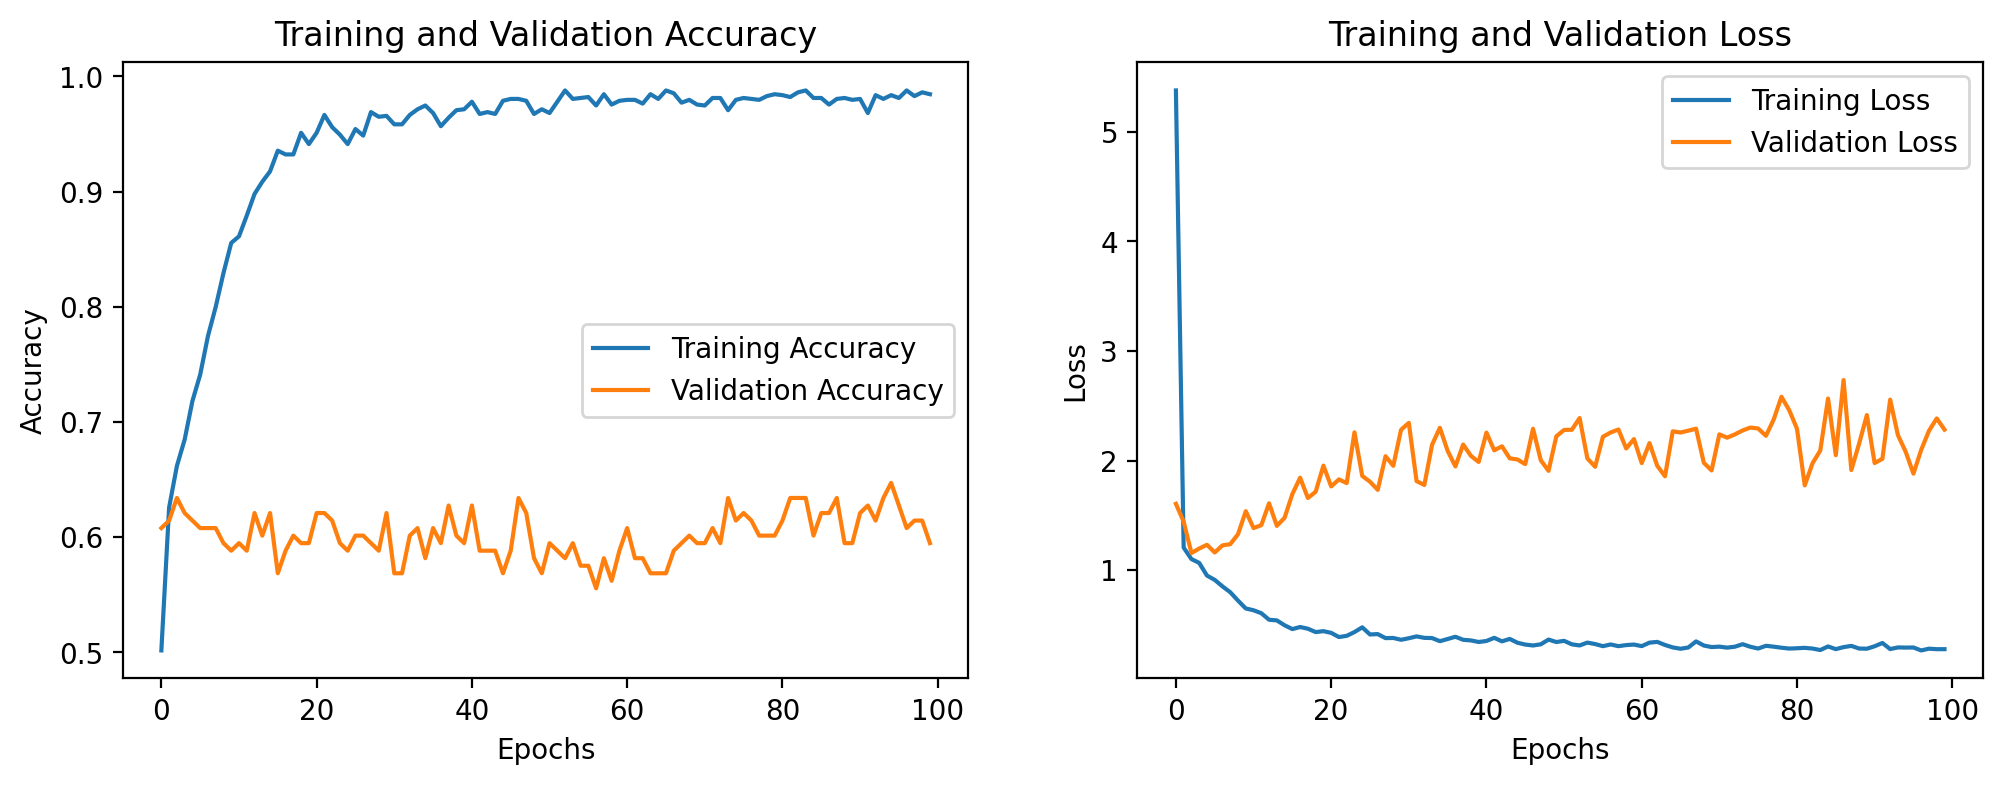

In [259]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()


```The hyperparameter search is complete. 
Parameters:
Filters: 128 and 192
Dense Units: 64
Dropout: 0.3, 0.3, 0.4
Regularization: 0.001
Optimizer: adam
Activation: relu
Batch Size: 32
Epoch: 25

20/20 - 0s - loss: 0.9036 - accuracy: 0.6095 - 245ms/epoch - 12ms/step
Test accuracy: 0.6094771027565002


- Then running with SMOTE

```The hyperparameter search is complete. 
Best parameters:
Filters: 192 and 128
Dense Units: 128
Dropout: 0.4, 0.4, 0.3
Regularization: 0.001
Activation: tanh
Batch Size: 48
Epoch: 30


5/5 - 0s - loss: 1.5005 - accuracy: 0.6667 - 94ms/epoch - 19ms/step
Test accuracy: 0.6666666865348816

* Adding Tempo to the features

Looking with new features and first + last notes:

```The hyperparameter search is complete. 
Best parameters:
Filters: 192 and 128
Dense Units: 64
Dropout: 0.4, 0.3, 0.3
Regularization: 0.0001
Activation: tanh
Batch Size: 48
Epoch: 100

Test accuracy: 0.647826075553894


## new
max tokens 500

```
The hyperparameter search is complete. 
Best parameters:
Filters: 64 and 64
Dense Units: 128
Dropout: 0.4, 0.3, 0.3
Regularization: 0.001
Activation: relu
Batch Size: 32
Epoch: 30

Test accuracy: 0.6209150552749634


* New with smote 500 tokens

```The hyperparameter search is complete. 
Best parameters:
Filters: 64 and 192
Dense Units: 256
Dropout: 0.4, 0.3, 0.5
Regularization: 0.0001
Activation: relu
Batch Size: 24
Epoch: 100

Test accuracy: 0.6601307392120361

* New smote 200 tokens

```The hyperparameter search is complete. 
Best parameters:
Filters: 128 and 128
Dense Units: 64
Dropout: 0.3, 0.3, 0.5
Regularization: 0.0001
Activation: tanh
Batch Size: 24
Epoch: 15
Test accuracy: 0.6535947918891907
